In [12]:
import cv2 as cv
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd
import itertools
from scipy import spatial

<h3> Helper Functions </h3>

In [13]:
def calculate_angle(line_1, line_2):
    """
    This function calculates the angle between the 2 lines.
    """    

    # Get nicer vector form
    l1 = [line_1[2]-line_1[0], line_1[3]-line_1[1]]
    l2 = [line_2[2]-line_2[0], line_2[3]-line_2[1]]
    # Get dot prod
    dot_prod = np.dot(l1, l2)
    # Get magnitudes
    mag_l1 = np.dot(l1, l1)**0.5
    mag_l2 = np.dot(l2, l2)**0.5
    # Get cosine value
    cos_ = dot_prod/mag_l1/mag_l2
    # Get angle in radians and then convert to degrees
    try:
        angle = math.acos(dot_prod/mag_l1/mag_l2)
    except:
        return 0
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360
    
    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 
        
        return ang_deg

In [14]:
def find_line_intersection(line1, line2):
    """
    This function finds the intersection of the 2 lines.
    """
    line1 = ((line1[0],line1[1]),(line1[2],line1[3]))
    line2 = ((line2[0],line2[1]),(line2[2],line2[3]))

    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return round(x), round(y)

In [15]:
def calculate_line_length(line):
    """
    This function calculates the line lenght.
    """
    x1,x2 = line[0],line[2]
    y1,y2 = line[1],line[3]
    
    diff_x = (x2 - x1)**2
    diff_y = (y2 - y1)**2
    
    return np.sqrt(diff_x + diff_y)

In [16]:
def get_slope(line):
    """
    This function calculates the slope of the line.
    """
    return np.arctan2(line[1] - line[3],line[0] - line[2])

In [17]:
def extend_line(line,amount):
    """
    This function returns the starting and ending point of the extended line. Lines are extended through the same direction.
    """
    slope = get_slope(line)
    
    new_x1 = int(line[0] - amount * np.cos(slope))
    new_y1 = int(line[1] - amount * np.sin(slope))

    new_x2 = int(line[2] + amount * np.cos(slope))
    new_y2 = int(line[3] + amount * np.sin(slope))
        
    return new_x1,new_y1,new_x2,new_y2

In [18]:
def create_line_dict(lines,x_axis):
    """
    Creates a line dictionary that have the values as line points, slope, and angle between the x axis.
    """
    line_dict = {}
    for idx,line in enumerate(lines):
        slope = round(get_slope(line),5)

        line_dict[idx] = {}
        line_dict[idx]['line'] = line
        line_dict[idx]['slope'] = slope
        line_dict[idx]['angle_x'] = round(calculate_angle(line,x_axis))
        
    return line_dict

In [19]:
def merge_lines(line_dict):
    """
    This function merges the similar lines by looking at their slope, etc.
    """
    merged_lines = {}
    for k,v in line_dict.items():

        flat_list = [item for sublist in list(merged_lines.values()) for item in sublist]
        #print(flat_list)

        if k not in flat_list:
            merged_lines[k] = []
            for k_2,v_2 in line_dict.items():
                if k == k_2:
                    continue
                inters = find_line_intersection(v['line'],v_2['line'])
                x1,y1 = inters if inters != None else (-1,-1)

                x1_in_range = True if (x1 >= 0 and x1 <= img.shape[1]) else False
                y1_in_range = True if (y1 >= 0 and y1 <= img.shape[0]) else False

                if (np.absolute(v['angle_x'] - v_2['angle_x']) <= 5 and x1_in_range and y1_in_range) or np.absolute(v['slope'] - v_2['slope']) <= 0.01:
                    merged_lines[k].append(k_2)
                    
    new_lines = []
    for k,v in merged_lines.items():
        new_lines.append(line_dict[k]['line'])
        '''
        if len(v) == 0:
            new_lines.append(lines[k])
        else:
            new_lines.append(lines[v[0]])'''
            
    return new_lines

<h3> Image Processing Algorithm </h3>

In [174]:
# read the image and convert it to BGR to RGB
img = cv.imread("images/soccer-3.jpg") 
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [175]:
img_height, img_width, _ = img.shape
img_height, img_width

(720, 1280)

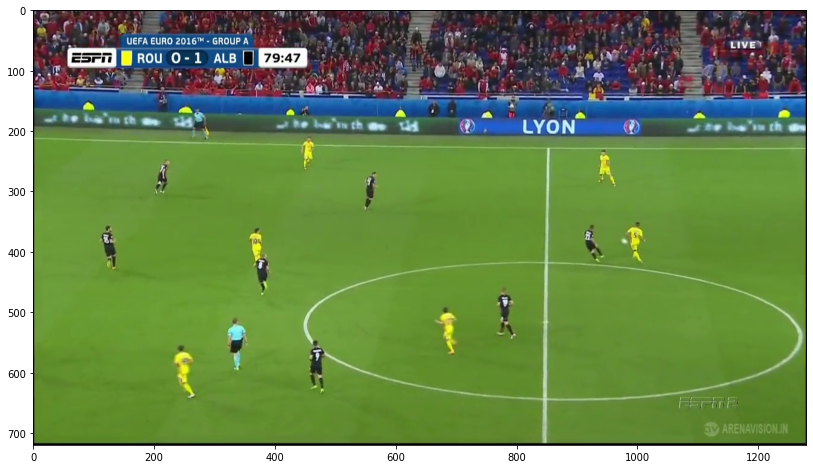

In [176]:
# visualize the original image
plt.figure(figsize=(14,8))
plt.imshow(img)

<h4> Playfield Extraction </h4>
<text> <br/> In order to extract the field, image is converted to HSV space and the most dominant color on the H space is considered as game field. Also, the neighbor colors are considered as game field within some threshold value. </text>

In [177]:
img_hsv = cv.cvtColor(img,cv.COLOR_RGB2HSV)

In [178]:
# split image into channels
h,s,v = cv.split(img_hsv)

In [179]:
# get the counts for every pixel value
unique, counts = np.unique(h, return_counts=True)
# get the most dominant one
most_freq = np.argmax(counts)
# threshold range
rng = 15

In [180]:
histr = cv.calcHist([img_hsv],[0],None,[256],[0,256])  # calculate the histogram

Text(0.5, 1.0, 'The most dominant pixel 44')

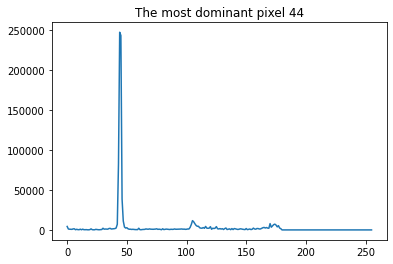

In [181]:
plt.plot(histr)
plt.title(f'The most dominant pixel {most_freq}')

Text(0.5, 1.0, 'H channel of the HSV')

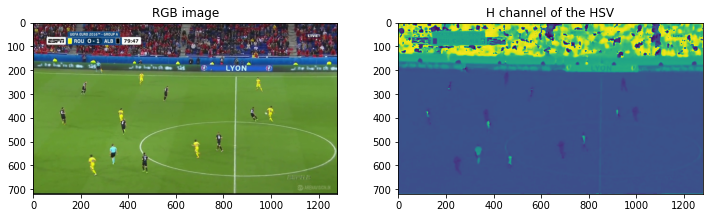

In [182]:
_, ax = plt.subplots(1,2,figsize=(12,12))

ax[0].imshow(img)
ax[0].set_title('RGB image')
ax[1].imshow(h)
ax[1].set_title('H channel of the HSV')

In [183]:
# binarized the h channel and get the playfield mask
mask = np.where(((h >= most_freq - rng) & (h <= most_freq + rng)),1,0)
mask = mask.astype('uint8')

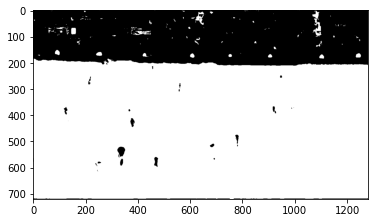

In [184]:
plt.imshow(mask,'gray')

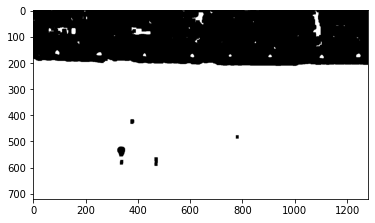

In [185]:
kernel = np.ones((3,3),np.uint8)

# erosion and dilation to get more accurate playfield
play_field = cv.dilate(mask,kernel,iterations=4) # 2
play_field = cv.erode(play_field,kernel,iterations=5) # 3
plt.imshow(play_field,'gray')

In [186]:
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

Text(0.5, 1.0, 'Tophat Image')

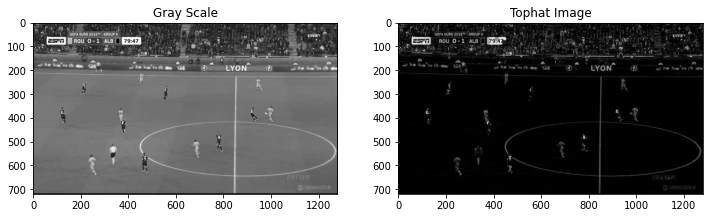

In [187]:
# by appliying tophat operation, white pixels becomes stronger so that we reduce the chance of missing any importan line.
tophat_img = cv.morphologyEx(gray_img,cv.MORPH_TOPHAT,kernel,iterations=6)

_, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(gray_img,'gray')
ax[0].set_title('Gray Scale')
ax[1].imshow(tophat_img,'gray')
ax[1].set_title('Tophat Image')

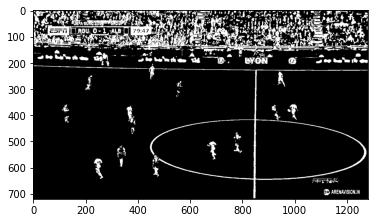

In [188]:
# binarized the image
im_bw = cv.threshold(tophat_img, 20, 255, cv.THRESH_BINARY)[1]

plt.imshow(im_bw,'gray')

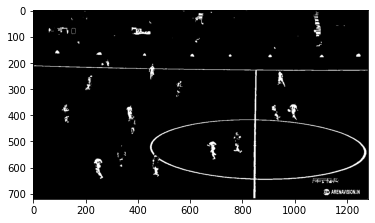

In [189]:
# apply the mask on the binary image
white_pixels = cv.bitwise_and(im_bw,im_bw,mask = play_field)
plt.imshow(white_pixels,'gray')

<h4> Line Detection </h4>
<text> <br/> In this part lines are detected, and intersection of these lines are detected. </text>

In [190]:
# detect the lines on the image
lines = cv.HoughLinesP(image=white_pixels, rho=1, theta=np.pi / 180, threshold=50) # ,minLineLength=20,maxLineGap=0
lines = lines.reshape(lines.shape[0],lines.shape[2])

In [191]:
# filter some of the lines by the relative length to the input image
filtered_lines = lines[np.apply_along_axis(calculate_line_length, 1, lines) / img_width >= 0.07]

Text(0.5, 1.0, 'Filtered Lines: 16')

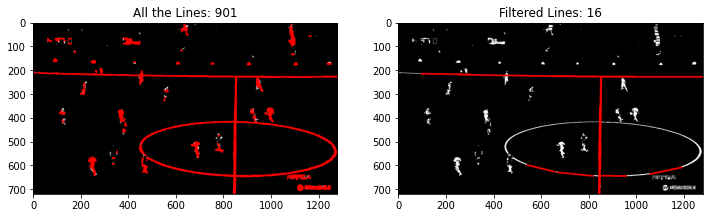

In [192]:
copy_image = white_pixels.copy()
copy_image = cv.cvtColor(copy_image,cv.COLOR_GRAY2RGB)
for idx,line in enumerate(lines):
    x1,y1 = line[0],line[1]
    x2,y2 = line[2], line[3]
    cv.line(copy_image, (x1,y1), (x2,y2), (255, 0, 0), thickness=6)

copy_image2 = white_pixels.copy()
copy_image2 = cv.cvtColor(copy_image2,cv.COLOR_GRAY2RGB)
for idx,line in enumerate(filtered_lines):
    #line = line[0]
    
    x1,y1 = line[0],line[1]
    x2,y2 = line[2], line[3]
    cv.line(copy_image2, (x1,y1), (x2,y2), (255, 0, 0), thickness=6)
    
_, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(copy_image,'gray')
ax[0].set_title(f"All the Lines: {len(lines)}")
ax[1].imshow(copy_image2,'gray')
ax[1].set_title(f"Filtered Lines: {len(filtered_lines)}")

In [193]:
# define and x axis as line, becuase we will calculate the length between the x axis and the lines.
# therefore we can detect the center lines if angle between the line and x axis close to 90 degrees.
x_axis = [0,img.shape[0],img.shape[1],img.shape[0]]

In [194]:
line_dict = create_line_dict(filtered_lines,x_axis) # create the line dictionary
line_dict[0] # show the first element of line dictionary

{'line': array([ 98, 216, 303, 219], dtype=int32),
 'slope': -3.12696,
 'angle_x': 1}

In [195]:
merged_lines = merge_lines(line_dict)
print(f"There are {len(merged_lines)} lines left.")

There are 4 lines left.


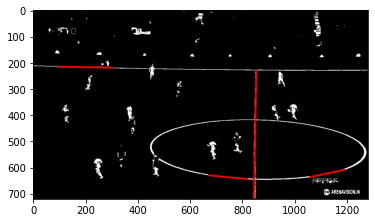

In [196]:
copy_image2 = white_pixels.copy()
copy_image2 = cv.cvtColor(copy_image2,cv.COLOR_GRAY2RGB)
for idx,line in enumerate(merged_lines):
    #line = extend_line(line,img_width)
    
    x1,y1 = line[0],line[1]
    x2,y2 = line[2], line[3]
    cv.line(copy_image2, (x1,y1), (x2,y2), (255, 0, 0), thickness=6)
    
plt.imshow(copy_image2)

In [197]:
# find if there are any mid line by look the angle between the x axis
mid_line = None
is_mid_line = False
for line in merged_lines:
    angle = calculate_angle(line,x_axis)
    if angle >= 85 and angle <= 95:
        is_mid_line = True
        mid_line = line
print(f"Center line: {mid_line}")

Center line: [844 716 853 229]


<h4> Homography Computation </h4>
<text> <br/> In this part best homography is found for 2 different cases as penalty field and center field </text>

In [198]:
import random
# import ransac algorithm to fit the ellipse 
import ransac.core as ransac
from ransac.models.conic_section import ConicSection

In [199]:
def get_candidate_points(intersection_points,height,width):
    """
    This function filters the unnecassary intersection points and returns the 4 combinations of the candidate points.
    """
    
    marigin_width = 300
    marigin_height = 300
    candidate_points = []
    for point in intersection_points:
        if point[0] < 0 and point[1] < 0:
            print(point,"is eliminated")
            continue
        elif (point[0] < -marigin_width or point[0] > width + marigin_width) or (point[1] < -marigin_height or point[1] > height + marigin_height):
            print(point,"is eliminated")
            continue
        else:
            candidate_points.append(point)
    
    # get 4 combinations of candidate_points
    list_of_dst_list = []
    for cp in itertools.combinations(candidate_points,4):
        cp = np.array(cp)
        cp = cp[cp[:, 1].argsort()]

        # 0: upper_left, 1: upper_right
        upper_points = cp[:2]
        upper_points = upper_points[upper_points[:, 0].argsort()]
        # 0: bottom_left, 1: bottom_right
        bottom_points = cp[2:]
        bottom_points = bottom_points[bottom_points[:, 0].argsort()]
        # 0: upper_left, 1: upper_right, 2: bottom_left, 3: bottom_right
        dst_points = np.append(upper_points,bottom_points,axis=0)
        list_of_dst_list.append(dst_points)
        
    return list_of_dst_list

In [200]:
def get_the_best_homography(src_list,intersection_points,bw_img,src_model):
    """
    This function calculates the homography matrix for every possible candidate points, and selects the best one with the
    highest cosine similarity score. Inverse homography from 2D model to src image.
    """
    
    src_pts = np.array(src_list).reshape(-1,1,2)
    width,height = bw_img.shape[1],bw_img.shape[0] #src image width and height
    
    candidate_dst_list = get_candidate_points(intersection_points,height,width)
    
    max_sim = 0
    best_points = None
    best_plan_view = None
    
    plan_views = []
    #candidate_dst_list = [[[82, 401], [502, 365],[748, 697],[1341,604]]]
    for idx,dst_list in enumerate(candidate_dst_list):
        dst_pts = np.array(dst_list).reshape(-1,1,2)
        # find homography
        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        plan_view = cv.warpPerspective(src_model, H, (width, height))
        
        plan_view_bw = cv.cvtColor(plan_view,cv.COLOR_BGR2GRAY)
        plan_view_bw = np.where(plan_view_bw > 150,255,0)
        plan_views.append(plan_view_bw)
        
        similarity = -1 * (spatial.distance.cosine(bw_img.flatten()/255, plan_view_bw.flatten()/255) - 1)
        
        # completely dark images can have high white pixel match ratio. put a threshold at least having some white pixel counts
        if (plan_view_bw == 255).sum() >= (bw_img == 255).sum() / 10:
            matched_white_pixels = ((plan_view_bw == bw_img) & (bw_img == 255)).sum() / (plan_view_bw == 255).sum()
        else:
            matched_white_pixels = 0
        
        similarity = 0.7*similarity + 0.3*matched_white_pixels
        print(idx,similarity,max_sim)
        
        if similarity > max_sim and similarity < 0.9:
            #print(f"Best cosine similarity so far: {similarity}")
            max_sim = similarity
            best_points = dst_pts
            best_plan_view = plan_view_bw
            
    return max_sim, best_points, best_plan_view, plan_views

In [208]:
def fit_ellipse(points,img):
    """
    This function fits the ellipse to set of points by using RANSAC method, and returns the ellipse points.
    """
    # create the ransac model with conic section
    modeller = ransac.Modeler(ConicSection, number_of_trials=5000,acceptable_error=10)
    # fit the ransac model
    consensus_conic_section, inliers, outliers = modeller.ConsensusModel(points)
    
    # get the center point and other paramters of the ellipse formula
    center, a, b, theta = consensus_conic_section.EllipseParameters()
    
    # center,up,down,left,right
    fitted_points = [[int(center[0]),int(center[1])],[int(center[0]-a),int(center[1])],[int(center[0]+a),int(center[1])],
                     [int(center[0]),int(center[1]-b)],[int(center[0]),int(center[1]+b)]]
    
    ellipse_points = consensus_conic_section.EllipsePoints()

    for ellipse_pt_ndx in range(0, len(ellipse_points) - 1):
        p1 = ellipse_points[ellipse_pt_ndx]
        p2 = ellipse_points[ellipse_pt_ndx + 1]
        cv.line(img, p1, p2, (255, 0, 0), thickness=3)
    cv.line(img, ellipse_points[0], ellipse_points[-1], (255, 0, 0), thickness=6)

    for ((x, y), d) in inliers:
        cv.circle(img, (x, y), 6, (0, 255, 0),-1)
    for ((x, y), d) in outliers:
        cv.circle(img, (x, y), 6, (0, 0, 255),-1)
        
    return fitted_points, img

In [202]:
def compute_the_homography(src_img,model_img,src_list,model_list):
    """
    This function calculates the final homography and warps the image to the 2D Model.
    """
    src_pts = np.array(src_list).reshape(-1,1,2)
    dst_pts = np.array(model_list).reshape(-1,1,2)
    
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    
    plan_view = cv.warpPerspective(src_img, H, (model_img.shape[1], model_img.shape[0]))
    
    for i in range(0,model_img.shape[0]):
        for j in range(0, model_img.shape[1]):
            if(plan_view.item(i,j,0) == 0 and plan_view.item(i,j,1) == 0 and plan_view.item(i,j,2) == 0):
                plan_view.itemset((i,j,0),model_img.item(i,j,0))
                plan_view.itemset((i,j,1),model_img.item(i,j,1))
                plan_view.itemset((i,j,2),model_img.item(i,j,2))
            
    return plan_view

In [203]:
# read the 2d model image
model_2d = cv.imread("images/model-2d.png")
model_2d = cv.cvtColor(model_2d,cv.COLOR_BGR2RGB) 

C:\Users\Omer\AppData\Local\Temp\ipykernel_17196\1637845570.py:15: RuntimeWarning: invalid value encountered in true_divide
  cos_ = dot_prod/mag_l1/mag_l2
C:\Users\Omer\AppData\Local\Temp\ipykernel_17196\1637845570.py:18: RuntimeWarning: invalid value encountered in true_divide
  angle = math.acos(dot_prod/mag_l1/mag_l2)


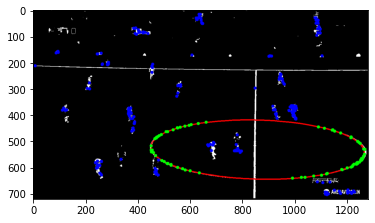

In [209]:
if not is_mid_line:
    
    intersection_points = []
    for idx,line1 in enumerate(merged_lines):
        
        for line2 in merged_lines[idx+1:]:
            try:
                intersection = find_line_intersection(extend_line(line1,img_height),extend_line(line2,img_height))
                intersection_points.append(intersection)
            except:
                print('no intersection')
    
    # left, right
    model_points_list = [[[25,75],[100,75],[25,265],[100,265]],[[440, 75], [515, 75], [440, 265], [515, 265]]]
    
    # try for left and right seperately
    cos_sim, fit_points, plan_view,pws = get_the_best_homography(model_points_list[0],intersection_points,white_pixels,model_2d)
    cos_sim_r, fit_points_r, plan_view_r,pws_r = get_the_best_homography(model_points_list[1],intersection_points,white_pixels,model_2d)
    
    if cos_sim_r > cos_sim:
        fit_points = fit_points_r
        plan_view = plan_view_r
    
    plt.imshow(plan_view,'gray')
    plt.title(f'Cosine Sim: {cos_sim}')
else:    
    xy_tuples = []
    for idx,line in enumerate(lines):
        angle = calculate_angle(line,mid_line)
        
        if (angle >= 10 and angle <= 85) or (angle >= 100 and angle <= 170):
            x1,y1 = line[0],line[1]
            x2,y2 = line[2], line[3]

            x = int((x1 + x2) / 2)
            y = int((y1 + y2) / 2)
            
            xy_tuples.append(((x,y),0))
            
    copy_image = white_pixels.copy()
    copy_image = cv.cvtColor(copy_image,cv.COLOR_GRAY2RGB)
    
    fit_points,ellipse_fitted_img = fit_ellipse(xy_tuples,copy_image)
    # coordinates of the points of circular area for 2d model
    model_points_list = [[[270,170],[225,170],[315,170],[270,125],[270,215]]]
    
    plt.imshow(ellipse_fitted_img)

In [210]:
final_result = compute_the_homography(img,model_2d,fit_points,model_points_list[0])

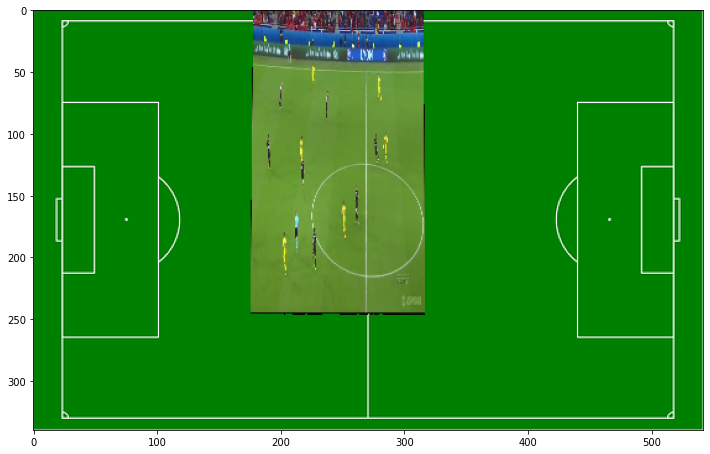

In [211]:
plt.figure(figsize=(12,12))
plt.imshow(final_result)